In [1]:
import os
import cv2
import sys
import random
import math
import re
import numpy as np
import pandas as pd 
import warnings
import tensorflow as tf
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
import ntpath
import itertools
import urllib
import json
import base64
import string
import keras 

import mrcnn.model as modellib

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log
from mrcnn.config import Config
from tensorflow.python.keras.backend import set_session

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    NAME = "tabledataset"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2  # Background + class1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

/Users/adeshgautam/.pyenv/versions/3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/adeshgautam/.pyenv/versions/3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/adeshgautam/.pyenv/versions/3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/adeshgautam/.pyenv/ve

In [2]:
# Directory to save logs and trained model
MODEL_DIR = 'logs'
custom_WEIGHTS_PATH = "models/mask_rcnn_tabledataset_0024_large.h5"  # TODO: update this path

global graph
graph = tf.get_default_graph() 

config = BalloonConfig()
dataset = {}

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

DEVICE = "/cpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

session = tf.Session()
init = tf.global_variables_initializer()
set_session(session)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
def model_predict(image_path):
    image = skimage.io.imread(image_path)

    dataset['class_names'] = ['BG', 'table', 'column'] 
    results = ''
    with graph.as_default():
        results = model.detect([image], verbose=1)
    r = results[0]
    return r

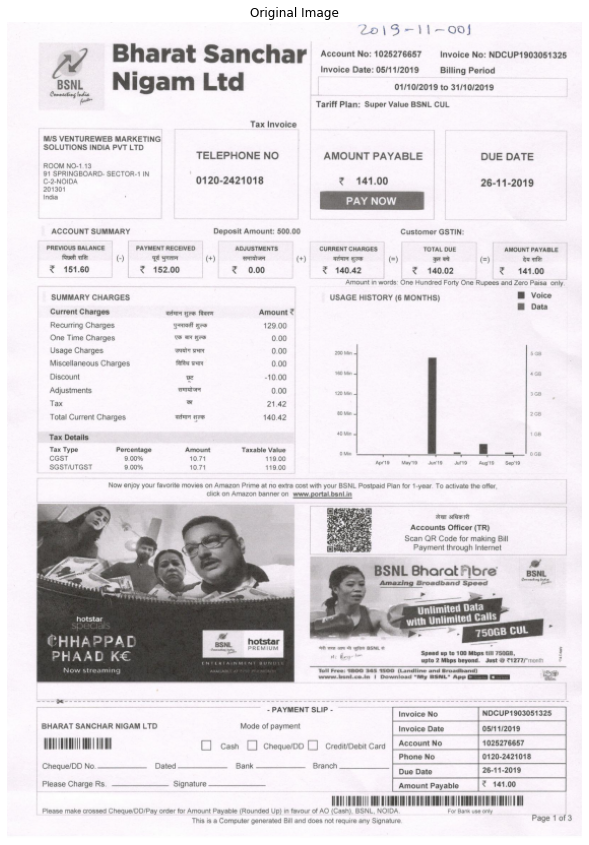

In [4]:
image_path = 'env_data/test/000010.png'
image = skimage.io.imread(image_path)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [5]:
r = model_predict(image_path)

Processing 1 images
image                    shape: (803, 566, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


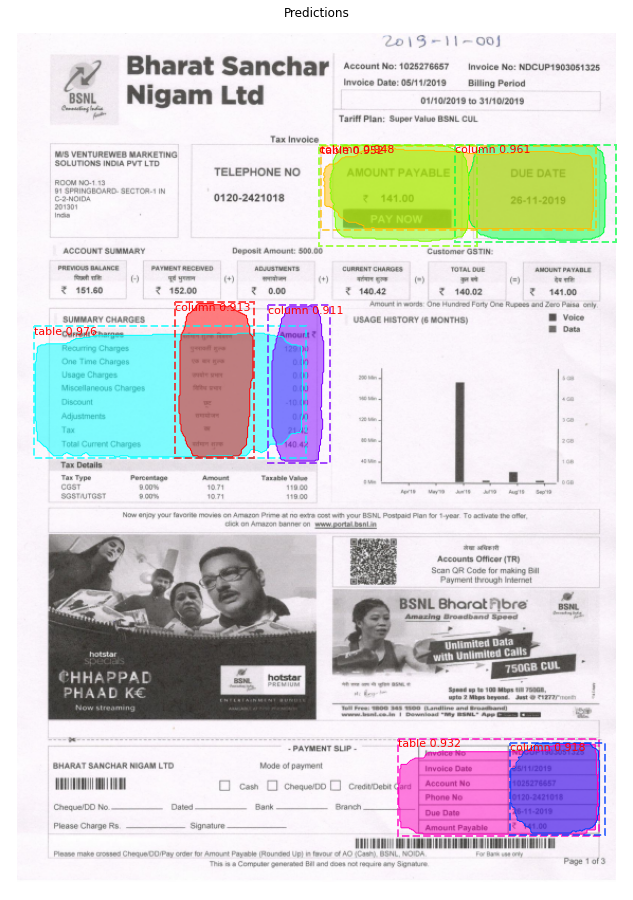

In [6]:
ax = get_ax(1)
masked_image = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset['class_names'], r['scores'], ax=ax,
                            title="Predictions", show_mask=True)

## Filter out False Positives using IOU

In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:
IOU_THRESH = 0.3
tables = []

for box1, cid1, score1 in zip(r['rois'], r['class_ids'], r['scores']): 
    if cid1==1:
        tables.append([box1, cid1, score1])

table_groups = []
for tab_data in tables:
    box1, cid1, score1 = tab_data[0], tab_data[1], tab_data[2]
    table_group = pd.DataFrame(columns=['x1','y1','x2','y2','class_id','score'])
    
    for box2, cid2, score2 in zip(r['rois'], r['class_ids'], r['scores']):
        if cid2==2:
            bb1 = {'x1':box1[0], 'y1':box1[1], 'x2':box1[2], 'y2':box1[3]}
            bb2 = {'x1':box2[0], 'y1':box2[1], 'x2':box2[2], 'y2':box2[3]}
            iou = get_iou(bb1, bb2)
            if iou > IOU_THRESH:
#                 table_group.append([box2, cid2, score2])
                df = pd.DataFrame([[box2[0], box2[1], box2[2], box2[3], cid2, score2]], 
                                columns=['x1','y1','x2','y2','class_id','score'])
                table_group = table_group.append(df)                
    table_group = table_group.sort_values(by=['x1','y1'])
    table_groups.append([[box1, cid1, score1], table_group])

In [9]:
from pprint import pprint

pprint(table_groups)

[[[array([277,  15, 402, 273], dtype=int32), 1, 0.9757185],
  Empty DataFrame
Columns: [x1, y1, x2, y2, class_id, score]
Index: []],
 [[array([106, 287, 186, 547], dtype=int32), 1, 0.9517326],
      x1   y1   x2   y2 class_id     score
0  105  285  201  435        2  0.948081
0  105  414  197  566        2  0.961323],
 [[array([667, 360, 759, 550], dtype=int32), 1, 0.9323313],
      x1   y1   x2   y2 class_id     score
0  671  466  758  556        2  0.918298]]


# Extract Text

In [10]:
import pytesseract

from super_resolution.execute import *

## Here Resolution of cropped images is improved using super-resolution so that OCR can be effective

## To increase the image Quality increase scale with multiples of 2

## Extract data from only tables

In [21]:
SCALE = 2

Progressively Scanning: 100%|█████████████████████████████████████████| 7/7 [00:18<00:00,  2.62s/it]


Channels = 3, Image Shape = 516 x 250


Progressively Scanning:   0%|                                                 | 0/4 [00:00<?, ?it/s]

Table 0
                Column 1     Column 2 Column 3               Column 4  \
0       Current Charges:  Adjustments      Tax  Total Curret Charges:   
1      Recurring Charges                                                
2       One Time Charges                                                
3          Usage Charges                                                
4  Miscellaneous Charges                                                

       Column 5 Column 6  
0  ‘oho pee fer           
1     Seve ogee          
2         Serge           
3                         
4                         


Progressively Scanning: 100%|█████████████████████████████████████████| 4/4 [00:10<00:00,  2.69s/it]


Channels = 3, Image Shape = 520 x 160


Progressively Scanning:   0%|                                                 | 0/5 [00:00<?, ?it/s]

Table 1
                  Column 1              Column 2 Column 3
0  AMOUNT PAYABLE DUE DATE  z= 141.00 26-11-2019  PAY NOW
1                                                       
2                                                        
3                                                        
4                                                        


Progressively Scanning: 100%|█████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Channels = 3, Image Shape = 380 x 184
Table 2
  Column 1 Column 2 Column 3      Column 4        Column 5 Column 6  \
0               ard             Invoice No        Due Date            
1                             Invoice Date  Amount Payable            
2                               Account No                            
3                                 Phone No                            
4                                                                     

           Column 7  Column 8 Column 9  
0  NOCUP 1903051325  @ 141.00           
1        05/11/2019                    
2        1025276657                     
3      0420-2421018                     
4        26-11-2019                     


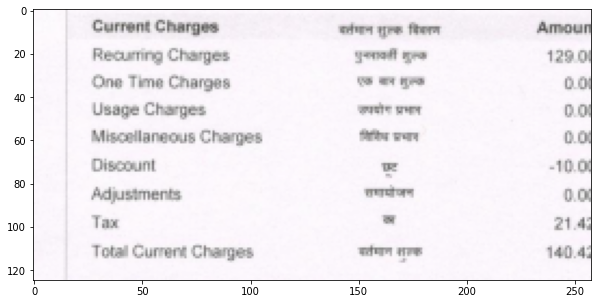

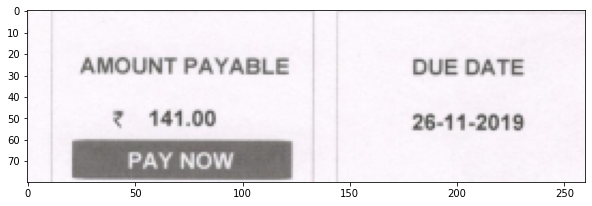

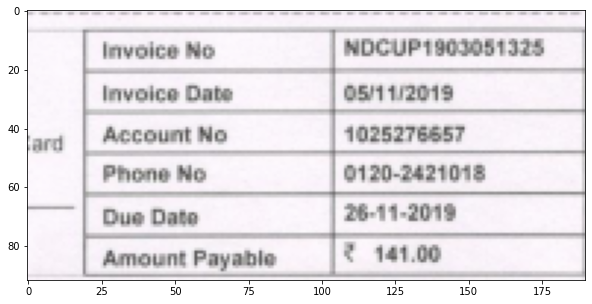

In [22]:
for i, group in enumerate(table_groups):
    box = group[0][0]
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    cropped = image[xmin:xmax, ymin:ymax]

    ## Uncomment to use super-resolution model to increase the cropped image's resolution
    img = upscale_image(cropped, scale=SCALE)
    np_img = np.asarray(img)
    
    tab_data = pytesseract.image_to_string(np_img)
    table_columns_data = tab_data.split('\n\n')

    max_lines = max([len(i) for i in table_columns_data])
    final_columns = []

    for data in table_columns_data:
        data = data.split('\n')
        if len(data)<max_lines:
            data += ['' for _ in range(max_lines-len(data))]
        final_columns.append(data)

    cols = ['Column '+str(i+1) for i in range(len(final_columns))]
    data_dict = {colname:col for colname, col in zip(cols, final_columns)}
    df = pd.DataFrame(data_dict)
    print('Table '+ str(i))
    print(df.head())

    plt.figure(figsize=(10,10))
    plt.imshow(cropped)

## Extract data using Columns

Progressively Scanning: 100%|█████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


Channels = 3, Image Shape = 300 x 192


Progressively Scanning: 100%|█████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


Channels = 3, Image Shape = 304 x 184


Progressively Scanning:   0%|                                                 | 0/5 [00:00<?, ?it/s]

Table  1 :
         Column 1    Column 2
0  AMOUNT PAYABLE    DUE DATE
1                            
2        2 141.00  26-11-2019
3                           
4         PAY NOW             



Progressively Scanning: 100%|█████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Channels = 3, Image Shape = 180 x 174
Table  2 :
          Column 1
0  NDCUP1903051325
1       05/11/2019
2       1025276657
3     0120-2421018
4       26-11-2019 



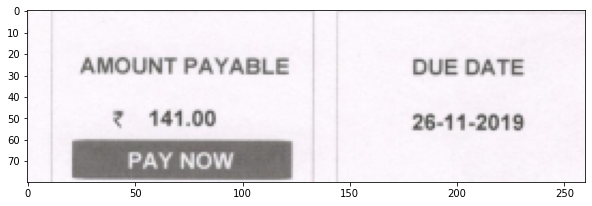

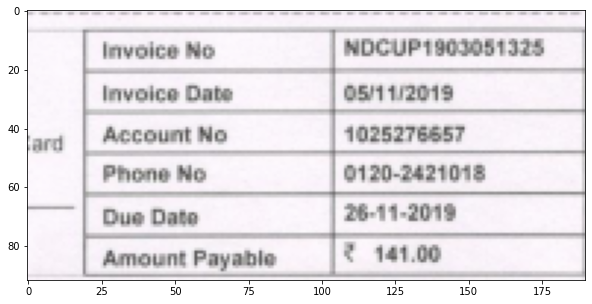

In [24]:
for i, group in enumerate(table_groups):
    if len(group[1])!=0:
        table_columns_data = []
        
        for column_data in group[1].iterrows():
            box = column_data[1]
            xmin = box['x1']
            ymin = box['y1']
            xmax = box['x2']
            ymax = box['y2']
            cropped = image[xmin:xmax, ymin:ymax]

            ## Uncomment to use super-resolution model to increase the cropped image's resolution
            img = upscale_image(cropped, scale=SCALE)
            np_img = np.asarray(img)

            col_data = pytesseract.image_to_string(np_img)
            lines = col_data.split('\n')
            table_columns_data.append(lines)
        
        box = group[0][0]
        xmin = box[0]
        ymin = box[1]
        xmax = box[2]
        ymax = box[3]
        cropped = image[xmin:xmax, ymin:ymax]
        plt.figure(figsize=(10,10))
        plt.imshow(cropped)
            
        max_lines = max([len(i) for i in table_columns_data])
        final_columns = []

        for data in table_columns_data:
            if len(data)<max_lines:
                data += ['' for _ in range(max_lines-len(data))]
            final_columns.append(data)
            
        cols = ['Column '+str(i+1) for i in range(len(final_columns))]
        data_dict = {colname:col for colname, col in zip(cols, final_columns)}
        df = pd.DataFrame(data_dict)
        print('Table ', i, ':')
        print(df.head(),'\n')
        df.to_csv('Table '+ str(i) +'.csv', index=False)